In [1]:
import numpy as np
import pygame
import gameboardClass
import matplotlib.pyplot as plt

#Define parameters of the board

# Game parameters: 
# - 'N_row' and 'N_col' (integers) define the size of the game board.
# - 'tile_size' (2 or 4) determines whether the small tile set (2) or the large tile set (4) should be used.
# - 'max_tile_count' (integer) sets the maximum number of tiles to be placed in one game.
# - 'stochastic_prob' (float between 0 and 1) determines the probability of taking a random tile. 
#   When stochastic_prob=0, tiles are taken according to a predefined sequence. 
#   When stochastic_prob=1, all tiles are random. For values 0<stochastic_prob<1, there is a mixture of deterministic and random tiles.

# Training parameters:
# - 'alpha' is the learning rate in Q-learning or for the stochastic gradient descent in deep Q-networks.
# - 'epsilon' is the probability to choose a random action in the epsilon-greedy policy.
# - 'episode_count' is the number of episodes a training session lasts.

# Additional training parameters for deep Q-networks:
# - 'epsilon_scale' is the scale of the episode number where epsilon_N changes from unity to epsilon.
# - 'replay_buffer_size' is the size of the experience replay buffer.
# - 'batch_size' is the number of samples taken from the experience replay buffer for each update.
# - 'sync_target_episode_count' is the number of episodes between synchronizations of the target network.
N_row=4
N_col=4
tile_size=2
max_tile_count=50
stochastic_prob=0

alpha=0.2
epsilon=0
episode_count=1000

pygame 2.5.2 (SDL 2.28.3, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class HumanPlayer:
    def init_board(self,gameboard):
        self.episode=0
        self.reward_tots=[0]
        self.gameboard=gameboard

    def get_state(self):
        pass

    def next_turn(self,pygame):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                raise SystemExit("Game terminated")
            if event.type==pygame.KEYDOWN:
                if event.key == pygame.K_ESCAPE:
                    self.reward_tots=[0]
                    self.gameboard.fn_restart()
                if not self.gameboard.gameover:
                    if event.key == pygame.K_UP:
                        self.gameboard.fn_move(self.gameboard.tile_x,(self.gameboard.tile_orientation+1)%len(self.gameboard.tiles[self.gameboard.cur_tile_type]))
                    if event.key == pygame.K_LEFT:
                        self.gameboard.fn_move(self.gameboard.tile_x-1,self.gameboard.tile_orientation)
                    if event.key == pygame.K_RIGHT:
                        self.gameboard.fn_move(self.gameboard.tile_x+1,self.gameboard.tile_orientation)
                    if (event.key == pygame.K_DOWN) or (event.key == pygame.K_SPACE):
                        self.reward_tots[self.episode]+=self.gameboard.fn_drop()


#play the game, use arrow keys to play
player=HumanPlayer()  
gameboard=gameboardClass.TGameBoard(N_row,N_col,tile_size,max_tile_count,player,stochastic_prob)


In [3]:

def Evaluate(gameboard,agent,agent_evaluate=None,strategy_file='',evaluate_agent=True):
    if agent_evaluate is None:
        evaluate_agent=False

    if evaluate_agent:
        agent_evaluate.epsilon=0
        agent_evaluate.init_board(gameboard)
        agent_evaluate.load_strategy(strategy_file)

    if isinstance(gameboard.agent,HumanPlayer):
        # Define some colors for painting
        COLOR_BLACK = (0, 0, 0)
        COLOR_GREY = (128, 128, 128)
        COLOR_WHITE = (255, 255, 255)
        COLOR_RED =  (255, 0, 0)

        # Initialize the game engine
        pygame.init()
        screen=pygame.display.set_mode((200+gameboard.N_col*20,150+gameboard.N_row*20))
        clock=pygame.time.Clock()
        pygame.key.set_repeat(300,100)
        pygame.display.set_caption('Turn-based tetris')
        font=pygame.font.SysFont('Calibri',25,True)
        fontLarge=pygame.font.SysFont('Calibri',50,True)
        framerate=0;

        # Loop until the window is closed
        while True:
            if isinstance(gameboard.agent,HumanPlayer):
                gameboard.agent.next_turn(pygame)
            else:
                pygame.event.pump()
                for event in pygame.event.get():
                    if event.type==pygame.KEYDOWN:
                        if event.key==pygame.K_SPACE:
                            if framerate > 0:
                                framerate=0
                            else:
                                framerate=10
                        if (event.key==pygame.K_LEFT) and (framerate>1):
                            framerate-=1
                        if event.key==pygame.K_RIGHT:
                            framerate+=1
                gameboard.agent.next_turn()

            if evaluate_agent:
                agent_evaluate.get_state()
                agent_evaluate.set_action()

            if pygame.display.get_active():
                # Paint game board
                screen.fill(COLOR_WHITE)

                for i in range(gameboard.N_row):
                    for j in range(gameboard.N_col):
                        pygame.draw.rect(screen,COLOR_GREY,[100+20*j,80+20*(gameboard.N_row-i),20,20],1)
                        if gameboard.board[i][j] > 0:
                            pygame.draw.rect(screen,COLOR_BLACK,[101+20*j,81+20*(gameboard.N_row-i),18,18])

                if gameboard.cur_tile_type is not None:
                    curTile=gameboard.tiles[gameboard.cur_tile_type][gameboard.tile_orientation]
                    for xLoop in range(len(curTile)):
                        for yLoop in range(curTile[xLoop][0],curTile[xLoop][1]):
                            pygame.draw.rect(screen,COLOR_RED,[101+20*((xLoop+gameboard.tile_x)%gameboard.N_col),81+20*(gameboard.N_row-(yLoop+gameboard.tile_y)),18,18])

                screen.blit(font.render("Reward: "+str(agent.reward_tots[agent.episode]),True,COLOR_BLACK),[0,0])
                screen.blit(font.render("Tile "+str(gameboard.tile_count)+"/"+str(gameboard.max_tile_count),True,COLOR_BLACK),[0,20])
                if framerate>0:
                    screen.blit(font.render("FPS: "+str(framerate),True,COLOR_BLACK),[320,0])
                screen.blit(font.render("Reward: "+str(agent.reward_tots[agent.episode]),True,COLOR_BLACK),[0,0])
                if gameboard.gameover:
                    screen.blit(fontLarge.render("Game Over", True,COLOR_RED), [80, 200])
                    screen.blit(font.render("Press ESC to try again", True,COLOR_RED), [85, 265])

                pygame.display.flip()
                clock.tick(framerate)

Evaluate(gameboard,player)   

SystemExit: Game terminated

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
#Define standard Q learning agent

def convertToBinary(s,state_size=18):
    binary = np.array([int(i) for i in bin(s)[2:]])
    binary = np.pad(binary, (state_size - len(binary), 0), 'constant')
    return binary

class QLAgent:
    def __init__(self,alpha,epsilon,episode_count):
        # Initialize training parameters
        self.alpha=alpha
        self.epsilon=epsilon
        self.episode=0
        self.episode_count=episode_count

    def init_board(self,gameboard):
        
        #Set up and initialize the states, actions and Q-table and storage for the rewards
        self.gameboard=gameboard
        self.nr_of_rows = gameboard.N_row
        self.nr_of_cols = gameboard.N_col
        self.len_of_tiles = len(bin(len(gameboard.tiles)-1)[2:])
        self.board = gameboard.board
        self.tiles = gameboard.tiles
        self.tile_sequence = gameboard.tile_sequence
        self.reward_tots = np.array([0]*self.episode_count)
        
        self.nr_of_rotations=4
        self.nr_of_moves = self.nr_of_cols-1
        self.state_size = gameboard.N_col*gameboard.N_row+self.len_of_tiles
        self.nr_of_states = 2**self.state_size
        self.action_size = self.nr_of_moves*self.nr_of_rotations
        
        self.Q_table = np.zeros((self.nr_of_states,self.action_size))
        self.Q_target = self.Q_table

    def load_strategy(self, strategy_file):
        self.Q_table = np.loadtxt(strategy_file)
        self.Q_target = self.Q_table

    def get_state(self):
        #Convert board to binary list
        board = np.copy(self.gameboard.board.reshape(self.nr_of_cols*self.nr_of_rows,)).astype(int)
        board[board==-1] = 0
        #Convert tile to binary list
        tile = np.copy(self.gameboard.cur_tile_type)
        tile = convertToBinary(tile,self.len_of_tiles)   
        #Add binary lists
        state = np.append(tile,board)    
        #Convert binary list to int
        state = int("".join(str(i) for i in state),2)
        self.state = state
        
    def set_action(self):
        # Select action using epsilon-greedy policy
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.nr_of_moves*self.nr_of_rotations)            
        else:
            action = np.argmax(self.Q_table[self.state,:]) 
        #Extract rotation and movement from action parameter 
        tile_orientation = action % self.nr_of_rotations
        tile_x = int(action/self.nr_of_rotations)
        self.legalAction = self.gameboard.fn_move(tile_x,tile_orientation)
        self.action = action
        
    def train(self,old_state,reward):
        # Update the Q table using state and action stored as attributes in self and using function arguments for the old state and the reward
        if self.legalAction == 0:
            self.Q_table[old_state,self.action] += self.alpha*(reward+np.max(self.Q_table[self.state,:])-self.Q_table[old_state,self.action])
        else:
            self.Q_table[old_state,self.action] += -50 #penalty for illegal move

    def next_turn(self):
        if self.gameboard.gameover:
            self.episode+=1
            if self.episode%100==0:
                self.Q_target = self.Q_table
                print('episode '+str(self.episode)+'/'+str(self.episode_count)+' (reward: ',str(np.sum(self.reward_tots[range(self.episode-100,self.episode)])),')')
            if self.episode>=self.episode_count:
                np.savetxt('Q_table.txt',self.Q_table)
                raise SystemExit("Training finished")
            else:
                self.gameboard.fn_restart()
        else:
            # Select and execute action (move the tile to the desired column and orientation)
            self.set_action()
            old_state=np.copy(self.state)
            # Drop the tile on the game board
            reward=self.gameboard.fn_drop()   
            self.reward_tots[self.episode]+=reward
            # Read the new state
            self.get_state()
            # Update the Q-table using the old state and the reward
            self.train(old_state,reward)

Standard Q-learning to play Tetris

In [5]:
agent=QLAgent(alpha,epsilon,episode_count)
gameboard=gameboardClass.TGameBoard(N_row,N_col,tile_size,max_tile_count,agent,stochastic_prob)

while True:
    gameboard.agent.next_turn()



episode 100/1000 (reward:  -8906 )
episode 200/1000 (reward:  -7313 )
episode 300/1000 (reward:  -6154 )
episode 400/1000 (reward:  -5479 )
episode 500/1000 (reward:  -3031 )
episode 600/1000 (reward:  6400 )
episode 700/1000 (reward:  6400 )
episode 800/1000 (reward:  6400 )
episode 900/1000 (reward:  6400 )
episode 1000/1000 (reward:  6400 )


SystemExit: Training finished

KeyboardInterrupt: 

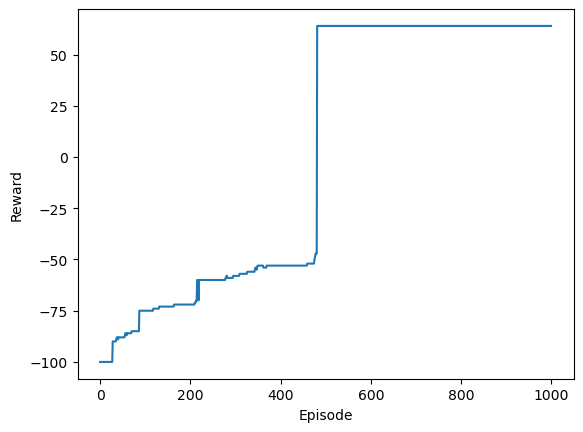

In [6]:
gameboard=gameboardClass.TGameBoard(N_row,N_col,tile_size,max_tile_count,player,stochastic_prob)
plt.plot(agent.reward_tots)
plt.ylabel('Reward')
plt.xlabel('Episode')
Evaluate(gameboard,player,agent,strategy_file='Q_table.txt')


We consider the more challenging scenario of a random sequence of tiles. Here, we expect standard Q learning to not converge to an (even close to) optimal solution in finite time. 

In [ ]:
stochastic_prob=1
epsilon=0.001
episode_count=200000

agent=QLAgent(alpha,epsilon,episode_count)
gameboard=gameboardClass.TGameBoard(N_row,N_col,tile_size,max_tile_count,agent,stochastic_prob)

while True:
    gameboard.agent.next_turn()



In [ ]:
gameboard=gameboardClass.TGameBoard(N_row,N_col,tile_size,max_tile_count,player,stochastic_prob)
plt.plot(agent.reward_tots)
running_mean=np.zeros(len(agent.reward_tots))
for i in range(len(agent.reward_tots)):
    running_mean[i]=np.mean(agent.reward_tots[max(0,i-500):i])
plt.plot(running_mean)
plt.ylabel('Reward')
plt.xlabel('Episode')
Evaluate(gameboard,player,agent,strategy_file='Q_table.txt')


Possibly, we can also let the user play the game again in these more difficult conditions. 

In [ ]:
Evaluate(gameboard,player)  

In [ ]:
import sys
sys.path.append('./deeplay')
import deeplay as dl
import torch
import random

    
class Quadruplet:
    def __init__(self, state, action, reward, new_state, terminal):
        self.state = state
        self.action = action
        self.new_state = new_state
        self.reward = reward
        self.terminal = terminal

class DQLAgent(dl.Application):
    # Agent for learning to play tetris using deep Q-learning
    def __init__(self,q_net,target_net, alpha, epsilon, epsilon_scale, replay_buffer_size, batch_size, sync_target_episode_count, episode_count,**kwargs):
        # Initialize training parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_scale = epsilon_scale
        self.replay_buffer_size = replay_buffer_size
        self.batch_size = batch_size
        self.sync_target_episode_count = sync_target_episode_count

        self.q_net = q_net
        self.target_net = target_net
        self.episode = 0
        self.episode_count = episode_count
        self.max_reward=0
        super().__init__(**kwargs)

    def init_board(self, gameboard):

        # Initialize board variables
        self.gameboard = gameboard
        self.nr_of_actions=gameboard.N_col*4
        self.len_of_tiles = len(bin(len(gameboard.tiles)-1)[2:])
        self.state_size = gameboard.N_col*gameboard.N_row+self.len_of_tiles

        # Initialize networks and storage
        self.reward_tots = np.zeros(self.episode_count)
        self.exp_buffer = []

    def load_strategy(self, strategy_file):
        #Load model weights
        model_state_dict = torch.load(strategy_file)
        self.q_net.load_state_dict(model_state_dict)
        self.target_net.load_state_dict(model_state_dict)

    def get_state(self):
        #Convert board to binary list
        board = np.copy(self.gameboard.board.reshape(16,)).astype(int)
        board[board==-1] = 0
        #Convert tile to binary list
        tile = np.copy(self.gameboard.cur_tile_type)
        tile = convertToBinary(tile,self.len_of_tiles)   
        #Combine binary lists and save as state
        state = np.append(tile,board)    
        self.state = torch.tensor(state, dtype=torch.float32)

    def set_action(self):
        r = random.random()
        with torch.no_grad():
            self.output = self.q_net(self.state.view(1, self.state_size)).detach().numpy()[0]
            if np.random.rand() < self.epsilon:
                action = np.random.randint(self.nr_of_actions)            
            else:
                action = np.argmax(self.output)
            #Extract rotation and movement from action parameter 
            rotation = action % 4
            position = int(action/4)  
            self.legalAction = self.gameboard.fn_move(position,rotation)
            self.action = action
 

    def training_step(self, batch):
        # Store states in a list
        states = []
        next_states = []
        for quadruple in batch:
            states.append(quadruple.state)
            next_states.append(quadruple.new_state)
        # Initialize targets and target mask
        targets = torch.zeros(self.batch_size, self.nr_of_actions)
        targets_mask = torch.zeros(self.batch_size, self.nr_of_actions)
        # Evaluate next state with target network
        with torch.no_grad():
            q_hat = self.target_net(torch.stack(next_states, dim=0))
        # Computes targets
        for idx, quadruple in enumerate(batch):
            if quadruple.terminal:
                y = quadruple.reward
            else:
                y = quadruple.reward + np.nanmax(q_hat[idx,:])
            targets[idx, quadruple.action] = y
            targets_mask[idx, quadruple.action] = 1
        # Evaluate old states, apply mask and update weights
        self.optimizer.zero_grad()
        outputs = self.q_net(torch.stack(states, dim=0)) * targets_mask
        loss = self.loss(outputs, targets)
        loss.backward()
        self.optimizer.step()

    def next_turn(self):
        if self.gameboard.gameover:
            self.episode += 1
            self.epsilon = max(0.001, 1 - self.episode / self.epsilon_scale)
            if self.episode % 100 == 0:
                current_reward = np.sum(self.reward_tots[range(self.episode - 100, self.episode)])
                print('episode ' + str(self.episode) + ' / ' + str(self.episode_count) + ' (reward: ', str(current_reward))
                if current_reward > self.max_reward:
                    self.max_reward = current_reward
                    torch.save(self.q_net.state_dict(), 'q_net.pth')
            if self.episode >= self.episode_count:
                raise SystemExit("Training finished")
            else:
                if (len(self.exp_buffer) >= self.replay_buffer_size) and (self.episode % self.sync_target_episode_count == 0):
                    self.target_net.load_state_dict(self.q_net.state_dict())
                self.gameboard.fn_restart()
        else:
            # Select and execute action (move the tile to the desired column and orientation)
            self.set_action()
            old_state = self.state
            # Drop the tile on the game board
            reward = self.gameboard.fn_drop()
            self.reward_tots[self.episode] += reward

            # Read the new state
            self.get_state()
            terminal = self.gameboard.gameover
            quadruplet = Quadruplet(old_state, self.action, reward, self.state, terminal)
            self.exp_buffer.append(quadruplet)
            if len(self.exp_buffer) >= self.replay_buffer_size:
                batch = random.sample(self.exp_buffer, self.batch_size)
                self.training_step(batch)
            if len(self.exp_buffer) >= self.replay_buffer_size + 1:
                self.exp_buffer.pop(0)







In [ ]:
alpha=0.001
episode_count=10000

epsilon_scale=5000
replay_buffer_size=10000
batch_size=64
sync_target_episode_count=100

hidden_units=[128,128]

q_net=dl.MultiLayerPerceptron(gameboard.N_row * gameboard.N_col + 2,hidden_units, gameboard.N_col*4)
q_net.blocks[:-1].activation = torch.nn.ReLU()
q_net=q_net.build()
print(q_net)
target_net=dl.MultiLayerPerceptron(gameboard.N_row * gameboard.N_col + 2,hidden_units,gameboard.N_col*4)
target_net.blocks[:-1].activation = torch.nn.ReLU() #GELU stabilizes training, ReLU works ok as well
target_net=target_net.build()

agent=DQLAgent(q_net,target_net,alpha,epsilon,epsilon_scale,replay_buffer_size,batch_size,sync_target_episode_count,episode_count,loss=torch.nn.MSELoss(),optimizer=torch.optim.Adam(q_net.parameters(),lr=alpha))
gameboard=gameboardClass.TGameBoard(N_row,N_col,tile_size,max_tile_count,agent,stochastic_prob)

while True:
    gameboard.agent.next_turn()



In [ ]:
gameboard=gameboardClass.TGameBoard(N_row,N_col,tile_size,max_tile_count,player,stochastic_prob)
plt.plot(agent.reward_tots)
running_mean=np.zeros(len(agent.reward_tots))
for i in range(len(agent.reward_tots)):
    running_mean[i]=np.mean(agent.reward_tots[max(0,i-500):i])
plt.plot(running_mean)
plt.ylabel('Reward')
plt.xlabel('Episode')
Evaluate(gameboard,player,agent,strategy_file='q_net.pth')
